<a href="https://colab.research.google.com/github/PinakW/DIssertation_expt/blob/main/Recent_Better_CadenceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
USE_ORIGINAL = 0
loss = 'categorical_crossentropy'

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
#For plotting the dataset
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
#Data pipeline preparation
import tensorflow as tf
from tensorflow.keras import layers
#model building
from tensorflow.keras import models
import tensorflow.keras.utils as tfutils
import os
import copy

In [ ]:
NUM_CLASSES = 10

DataSet = 'cifar10'
#'caltech101'
#'cifar10'
def num_samples_per_class(ds_train, get_top_10 = False, print_all = False):
    vals = np.unique(np.fromiter(ds_train.map(lambda x, y: y), int), return_counts=True)
    class_list = []
    class_hist = []
    for val,count in zip(*vals):
        if print_all==True:
            print(int(val), count)
        class_hist.append((val,count))
    if get_top_10 == True:
        sorted_tuple = sorted(class_hist, key=lambda t: t[-1], reverse=True)[:(NUM_CLASSES + 1)]    #+1 because we are going to remove "backround_google" i.e. 4
        class_list = [x for x,y in sorted_tuple]
    return class_list

def filter_fn(x, allowed_classes:list):
    allowed_classes = tf.constant(allowed_classes)
    isallowed = tf.equal(allowed_classes, tf.cast(x, allowed_classes.dtype))
    reduced_sum = tf.reduce_sum(tf.cast(isallowed, tf.float32))
    return tf.greater(reduced_sum, tf.constant(0.))

In [ ]:
#ds_train = tfds.load(DataSet, split='train + test[:75%]', as_supervised=True)
if DataSet == 'caltech101':
  ds_train, train_info = tfds.load(DataSet, split='train + test[:75%]', as_supervised=True, with_info = True)
else:
  ds_train, train_info = tfds.load(DataSet, split='train', as_supervised=True, with_info = True)
ds_test = tfds.load(DataSet, split='test', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete7YAVDD/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete7YAVDD/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
class_list = num_samples_per_class(ds_train, get_top_10=True)
if DataSet == 'caltech101':
  class_list = [i for i in class_list if i != train_info.features['label'].str2int('background_google')]
  class_list.sort()

"""for name in train_info.features['label'].names:
    print(name, train_info.features['label'].str2int(name))
"""

class_names = [train_info.features['label'].int2str(i) for i in class_list]
display(class_names)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
resized_ds_train = ds_train.filter(lambda x, y: filter_fn(y, class_list)) # as_supervised
resized_ds_test = ds_test.filter(lambda x, y: filter_fn(y, class_list))

In [ ]:
num_samples_per_class(resized_ds_train, print_all=True)

0 5000
1 5000
2 5000
3 5000
4 5000
5 5000
6 5000
7 5000
8 5000
9 5000


[]

In [ ]:
num_samples_per_class(resized_ds_test, print_all=True)

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


[]

In [ ]:
#Hyperparameters
if DataSet=='caltech101':
    IMG_SIZE = 60
elif DataSet=='cifar10':
    IMG_SIZE = 32
NUM_CHANNELS = 3
BATCH_SIZE=128

input_shape = (IMG_SIZE,IMG_SIZE,NUM_CHANNELS)
#Relabelling to avoid issues. Note that human readability is reduced by this
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(class_list, dtype=tf.int64),
        #values=tf.constant([tfutils.to_categorical(0, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(1, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(2, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(3, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(4, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(5, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(6, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(7, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(8, num_classes=NUM_CLASSES, dtype=np.int64), tfutils.to_categorical(9, num_classes=NUM_CLASSES, dtype=np.int64)],  dtype=tf.int64),
        values=tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  dtype=tf.int64)
    ),
    default_value= tf.constant(0,  dtype=tf.int64)
)

#This function will be used in the graph execution hence @tf.function prefix
@tf.function
def map_func(label):
    global class_list
    global loss
    mapped_label = table.lookup(label)
    if loss != 'sparse_categorical_crossentropy':
        mapped_label = tf.one_hot(indices=mapped_label, depth=NUM_CLASSES)
    print("Label = " + str(label) + "\t" + "Mapped Label = " + str(mapped_label))
    return mapped_label

#Preprocessing done as part of the graph
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

resize_layer = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

buffer_size = 30*NUM_CLASSES

#Preprocessing function which invokes above graphs
def prepare(ds, shuffle=False, augment=False, resize_only = False):
    global buffer_size
    global BATCH_SIZE
    

    # Resize and rescale all datasets.
    if resize_only==True:
        ds = ds.map(lambda x, y: (resize_layer(x), map_func(y)), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (resize_and_rescale(x), map_func(y)), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size)
        
    # Batch all datasets.
    #ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set.
    if augment:
        #f_ds = ds.filter(lambda x, y: filter_fn(y, [2,3,6]))    #[2,3,6] are the examples with lesser data. We are trying to bring back balance
        #f_ds_aug = f_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        #ds = ds.concatenate(f_ds_aug)
        #ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        #ds = ds.concatenate(ds_aug)
        ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.concatenate(ds_aug)

        
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resized_ds_train = prepare(resized_ds_train, augment=True)
resized_ds_test = prepare(resized_ds_test)

Label = Tensor("label:0", shape=(), dtype=int64)	Mapped Label = Tensor("one_hot:0", shape=(10,), dtype=float32)


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)>

<tf.Tensor: shape=(), dtype=int64, numpy=7>

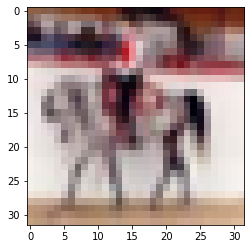

In [ ]:
for example in resized_ds_train.take(1):
  plt.imshow(example[0])
  display((example[-1]))
  display(tf.argmax(example[-1]))
  #display(train_info.features['label'].int2str(example[-1]))

In [ ]:
def num_samples_per_class_onehot(resized_ds_train, print_all=False):
    if loss != 'sparse_categorical_crossentropy':
        vals = np.unique(np.fromiter(resized_ds_train.map(lambda x, y: tf.argmax(y)), int), return_counts=True)
    else:
        vals = np.unique(np.fromiter(resized_ds_train.map(lambda x, y: y), int), return_counts=True)
    class_list = []
    class_hist = []
    for val,count in zip(*vals):
        if print_all==True:
            print(int(val), count)
        class_hist.append((val,count))
    class_hist.sort()
    return class_hist



In [ ]:
#Post prepare function, all the labels will be converted to one hot encoders. In order to get class-wise distribution, we will need to convert each one hot encoder into its label (temporarily)
#We need a new function to handle it
class_hist = num_samples_per_class_onehot(resized_ds_train)
display(class_hist)

[(0, 10000),
 (1, 10000),
 (2, 10000),
 (3, 10000),
 (4, 10000),
 (5, 10000),
 (6, 10000),
 (7, 10000),
 (8, 10000),
 (9, 10000)]

In [ ]:
#reg = tf.keras.regularizers.L2(0.01)
reg = tf.keras.regularizers.L1L2(l1 =0.0, l2 = 0.1)
#reg = tf.keras.regularizers.L1L2(l1 =0.0, l2 = 0.0)
#beta_regularizer = 0.1
#gamma_regularizer = 0.1

model = models.Sequential()

if USE_ORIGINAL == 1:
		display("Original CadenceNet")
		#model.add(resize_and_rescale)
		#model.add(data_augmentation)
		kernel_size = (5,5)
		model.add(layers.Conv2D(64, kernel_size, input_shape = input_shape, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		pool_size = (2,2)
		model.add(layers.MaxPool2D(pool_size))
		model.add(layers.Dropout(.2))

		kernel_size = (3,3)
		model.add(layers.Conv2D(192, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())                                                      #beta_regularizer = beta_regularizer, gamma_regularizer = gamma_regularizer
		model.add(layers.ReLU())
		pool_size = (2,2)
		model.add(layers.MaxPool2D(pool_size))
		model.add(layers.Dropout(.2))
	#model.add(layers.SpatialDropout2D(0.2))
	
		kernel_size = (3,3)
		model.add(layers.Conv2D(64, kernel_size, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		model.add(layers.Dropout(.2))
	
		kernel_size = (3,3)
		model.add(layers.Conv2D(128, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		pool_size = (2,2)
		model.add(layers.MaxPool2D(pool_size))
		model.add(layers.Dropout(.2))
		#model.add(layers.SpatialDropout2D(0.2))
	
		model.add(layers.Flatten())
		model.add(layers.Dropout(.2))
		#model.add(layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer = reg))
		model.add(layers.Dense(NUM_CLASSES, kernel_regularizer = reg))
		model.add(layers.Softmax())
else:
		display("Better CadenceNet")
		kernel_size = (3,3)
		model.add(layers.Conv2D(32, kernel_size, input_shape = input_shape, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		pool_size = (2,2)
		model.add(layers.MaxPool2D(pool_size))
		#model.add(layers.SpatialDropout2D(0.2))
	
		kernel_size = (3,3)
		model.add(layers.Conv2D(64, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		pool_size = (2,2)
		model.add(layers.SpatialDropout2D(0.1))
	
		kernel_size = (3,3)
		model.add(layers.Conv2D(128, kernel_size, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		pool_size = (2,2)
		#model.add(layers.SpatialDropout2D(0.2))


#		model.add(layers.MaxPool2D(pool_size))
	
		#kernel_size = (3,3)
		#model.add(layers.Conv2D(192, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		#model.add(layers.BatchNormalization())
		#model.add(layers.ReLU())
		#pool_size = (2,2)
		#model.add(layers.MaxPool2D(pool_size))

		kernel_size = (3,3)
		model.add(layers.Conv2D(64, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		pool_size = (2,2)
#		model.add(layers.MaxPool2D(pool_size))
		
		kernel_size = (3,3)
		model.add(layers.Conv2D(32, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
		model.add(layers.BatchNormalization())
		model.add(layers.ReLU())
		pool_size = (2,2)
		model.add(layers.MaxPool2D(pool_size))
	
		model.add(layers.Flatten())
		#model.add(layers.Dropout(.2))
		#model.add(layers.Dense(1000, kernel_regularizer = reg))
		#model.add(layers.Dropout(.02))
		model.add(layers.Dense(NUM_CLASSES, kernel_regularizer = reg))
		model.add(layers.Softmax())

'Better CadenceNet'

In [ ]:
def get_class_weights(class_hist):
    """
    Returns the class weights as a tf.Tensor. Class weights are inverse of the class frequencies
    Class frequencies are the number of samples of each class which we calculate in earlier steps
    """
    inv_freq = tf.convert_to_tensor([1.0/count for label, count in class_hist], dtype=tf.float32)
    return tfutils.normalize(inv_freq)


def weightedloss(y_true, y_pred, gamma, class_weight):
    """
    We assume that all arguments coming into this function are tf.Tensors type
    class_weights are basically alpha in focal loss paper
    """
    #ones = tf.convert_to_tensor(np.ones(shape=len(y_true)))
    a = tf.math.multiply(tf.math.pow(tf.math.subtract(1.0, y_pred), gamma), tf.math.log(y_pred))  #((1-pt)^gamma)log(pt)
    b = tf.math.multiply(-1.0, class_weight)                                                          #-alpha
    b = tf.math.multiply(b,a)    
    b = tf.math.multiply(b, y_true)
    return b
class WeightedLoss(tf.keras.losses.Loss):
    def __init__(self, gamma, class_weight=np.ones(shape=NUM_CLASSES, dtype=np.float32)):
        super().__init__()
        self.gamma = tf.convert_to_tensor(gamma)
        self.class_weight = tf.convert_to_tensor(class_weight, dtype=tf.float32)
    def call(self, y_true, y_pred):
        return weightedloss(y_true, y_pred, self.gamma, self.class_weight)

In [ ]:
Learning_Rate = 1e-3
#tf.keras.optimizers.Adam(learning_rate=Learning_Rate)     #OR tf.keras.optimizers.SGD(learning_rate=Learning_Rate, momentum=0.0)
opt = tf.keras.optimizers.SGD(learning_rate=Learning_Rate, momentum=0.9)

In [ ]:
###EITHER

#!pip install focal-loss
#from focal_loss import SparseCategoricalFocalLoss 
#model.compile( optimizer = opt, loss = SparseCategoricalFocalLoss(gamma=2), metrics=['accuracy'] )

In [ ]:
###OR
model.compile( optimizer = opt, loss = loss, metrics=['accuracy'] )

In [ ]:
###OR
#class_wts = get_class_weights(class_hist)
#display(class_wts)
#model.compile( optimizer = opt, loss = WeightedLoss(gamma=2.0, class_weight=class_wts), metrics=['accuracy'] )

In [ ]:
#model.summary()

In [ ]:
#h = model.fit( resized_ds_train, epochs=10)
resized_ds_train = resized_ds_train.batch(BATCH_SIZE)
resized_ds_test_unbatched = resized_ds_test
resized_ds_test = resized_ds_test.batch(BATCH_SIZE)

h = model.fit( resized_ds_train, epochs=80, validation_data = resized_ds_test)

Epoch 1/200
782/782 [==============================] - 52s 52ms/step - loss: 28.4867 - accuracy: 0.2170 - val_loss: 26.2618 - val_accuracy: 0.2581
Epoch 2/200
782/782 [==============================] - 39s 50ms/step - loss: 24.2580 - accuracy: 0.2897 - val_loss: 22.3200 - val_accuracy: 0.3084
Epoch 3/200
782/782 [==============================] - 40s 52ms/step - loss: 20.5617 - accuracy: 0.3310 - val_loss: 18.8664 - val_accuracy: 0.3463
Epoch 4/200
782/782 [==============================] - 40s 52ms/step - loss: 17.3568 - accuracy: 0.3605 - val_loss: 15.9191 - val_accuracy: 0.3702
Epoch 5/200
782/782 [==============================] - 41s 53ms/step - loss: 14.6509 - accuracy: 0.3832 - val_loss: 13.4597 - val_accuracy: 0.3877
Epoch 6/200
782/782 [==============================] - 40s 51ms/step - loss: 12.4054 - accuracy: 0.4020 - val_loss: 11.4389 - val_accuracy: 0.4033
Epoch 7/200
782/782 [==============================] - 40s 52ms/step - loss: 10.5701 - accuracy: 0.4192 - val_loss: 9.

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
#Evaluation and confusion matrix creation:
from sklearn.metrics import classification_report, confusion_matrix

x_test = np.asarray(list(map(lambda x: x[0], tfds.as_numpy(resized_ds_test_unbatched))))
y_test_orig = np.asarray(list(map(lambda x: x[1], tfds.as_numpy(resized_ds_test_unbatched))))

In [ ]:
predictions = model.predict(x_test)

In [ ]:
if loss!='sparse_categorical_crossentropy':
    false_arr = np.full(shape=len(class_list), fill_value = False)
    #y_pred = np.empty(shape=y_test_orig.shape[-1])
    i=0
    for i, pred in enumerate(predictions):
        temp_arr = copy.deepcopy(false_arr)
        np.put(temp_arr, np.argmax(pred), True)
        if i==0:
            y_pred = copy.deepcopy(temp_arr)
        else:
            y_pred = np.vstack([y_pred, temp_arr])
    display(y_pred.shape)
else:
    y_pred = np.argmax(predictions, axis=1)


In [ ]:
display(y_test_orig.shape)
display(y_pred.shape)

In [ ]:
print('Confusion Matrix')
if loss != 'sparse_categorical_crossentropy':
    matrix = confusion_matrix(y_test_orig.argmax(axis=1), y_pred.argmax(axis=1))
else:
    matrix = confusion_matrix(y_test_orig, y_pred)
display(matrix)

# Print Classification Report
print('Classification Report')
print(classification_report(y_test_orig, y_pred, target_names=class_names))

NOT using below things

In [ ]:
def ret_as_numpy():
    test = tfds.load(DataSet, split='test', as_supervised=True)
    test = prepare(test)
    test = tfds.as_numpy(test)
    return test

In [ ]:
test_as_np = ret_as_numpy()

In [ ]:
def evaluate_float_model(model, test):
    test_labels = []
    
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_example in enumerate(test):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        test_labels.append(np.argmax(test_example[-1]))
        test_image = test_example[0]
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        #display(test_image.shape)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        #test_image = np.expand_dims(test_image, axis=3).astype(np.float32)
        #display(test_image.shape)
        
        # Run inference.
        output = model(test_image, training=False)
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = output.numpy()
        #display(output[0])
        digit = np.argmax(output[0])
        prediction_digits.append(digit)
        
    print('\n')
    #display(output[0])
    #display(output)
    #display(digit)
    # Compare prediction results with ground truth labels to calculate accuracy.
    #display(prediction_digits)
    #display(test_labels)
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
test_accuracy_Float = evaluate_float_model(model, test_as_np)

print('Float test_accuracy:', test_accuracy_Float)

Float checkpoint

In [ ]:
! pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model

In [ ]:
q_aware_model = quantize_model(model)
q_aware_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy'])
q_aware_model.summary()

In [ ]:
quantize_train, quant_train_info = tfds.load(DataSet, split='train + test[:75%]', with_info=True, as_supervised=True)
filtered_quantize_train = quantize_train.filter(lambda x, y: filter_fn(y, class_list))

resized_quantize_train = prepare(filtered_quantize_train)

In [ ]:
resized_quantize_train = resized_quantize_train.batch(BATCH_SIZE)
h = q_aware_model.fit(resized_quantize_train, epochs=5, validation_data = resized_ds_test)

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

In [ ]:
def evaluate_model(interpreter, test):
    test_labels = []


    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_example in enumerate(test):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        test_labels.append(np.argmax(test_example[-1]))
        test_image = test_example[0]
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        #display(test_image.shape)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        #test_image = np.expand_dims(test_image, axis=3).astype(np.float32)
        #display(test_image.shape)
        interpreter.set_tensor(input_index, test_image)
        
        # Run inference.
        interpreter.invoke()
        
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        
    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [ ]:
#Models obtained from TfLiteConverter can be run in Python with Interpreter.
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
#Since TensorFlow Lite pre-plans tensor allocations to optimize inference, the user needs to call allocate_tensors() before any inference.
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter, test_as_np)

print('Quant TFLite test_accuracy:', test_accuracy)
#print('Quant TF test accuracy:', q_aware_model_accuracy)

In [ ]:
MODEL_DIR = "CadenceNet_Float"
model.save(MODEL_DIR, save_format="tf")

In [ ]:
!pip install -U tf2onnx==1.8.4
!python -m tf2onnx.convert --saved-model /content/CadenceNet_Float/ --output /content/CadenceNetOriginal_Float.onnx

In [ ]:
quant_file = "/content/CadenceNetOriginal_QAT.tflite"
open(quant_file, "wb").write(quantized_tflite_model)

In [ ]:

print("Float model in Mb: ", os.path.getsize("/content/CadenceNetOriginal_Float.onnx") / float(2**20))
print("Quantized model in Mb: ", os.path.getsize(quant_file) / float(2**20))
print("Float Model Accuracy: ", test_accuracy_Float)
print("Quantized Model Accuracy: ", test_accuracy)

In [ ]:
!pip install onnxruntime
import onnxruntime as rt

sess = rt.InferenceSession("/content/CadenceNetOriginal_Float.onnx")
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
x = np.random.random((1,IMG_SIZE,IMG_SIZE,NUM_CHANNELS))
x = x.astype(np.float32)
res = sess.run([output_name], {input_name: x})


In [ ]:
indices = tf.convert_to_tensor([0, 1, 2])
depth = 3
indic = tf.convert_to_tensor([3, 5, 8])
tf.math.multiply(indices, indic)

